# Multivariate Gaussian Hidden-Markov Model (HMM) directly on macro-series w/o dimensionality reduction

### 1. necessary imports & helpers

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from hmmlearn.hmm import GaussianHMM
from itertools import product

%matplotlib inline
sns.set_style('darkgrid')

### 2. load data

In [3]:
Z = pd.read_csv("data/macro_panel_standardized.csv", index_col=0, parse_dates=True)
Z

,gdp_yoy,inf_yoy,rate_3m_d1,rate_10y_d1,unemployment_d1
date,,,,,
1954-06-30,-2.263432,-1.030420,-0.410992,-0.224637,0.765015
1954-09-30,-1.557446,-1.291299,0.120248,-0.015858,0.243087
1954-12-31,-0.108478,-1.465614,0.183607,0.267484,-0.895664
1955-03-31,1.270170,-1.500869,0.281082,0.371874,-0.848216
1955-06-30,1.899856,-1.492280,0.363936,0.245115,-0.468632
...,...,...,...,...,...
2024-03-31,-0.037995,-0.115659,-0.089324,-0.642194,0.053295
2024-06-30,0.016863,-0.137507,-0.001596,0.617934,0.243087
2024-09-30,-0.112489,-0.327722,-0.386623,-1.126858,0.243087


### 3. split from ```pd.DataFrame``` into numpy arrays

In [26]:
X = Z.values
dates = Z.index
print(X.shape)

(284, 5)


### 4. BIC calculator
apparently `hmmlearn` doesn't ship with a BIC calculator (could probably just plugin sklearn or statsmodels somehow but I didn't feel like figuring that out right now and this is how chatGPT told me to calculate it (i.e. it could very well be wrong):

> $$\text{BIC} = -2\,\ell + p \,\log T,$$ where $p$ counts **free** parameters in means, covariances, start-prob, and the transition-matrix

In [5]:
def bic_score(model, LL, T, n_features):
    k = model.n_components

    p_means = k * n_features
    p_covs = k * (n_features + 1) / 2

    p_pi = k - 1
    p_trans = k * (k - 1)
    p_total = p_means + p_covs + p_pi + p_trans
    return -2 * LL + p_total * np.log(T)

ok I later discovered that hmmlearn models do ship with BIC, AIC, and LL attributes on model outputs
- See [the following docs demo](https://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_gaussian_model_selection.html)

### 5. hyper-parameter grid search
   - I'm going to do one grid search using chatGPT's BIC function and one following the libraries demo above ^
   - I want to see if the results differ and by how much becaus why not I guess

**5.1 ChatGPT BIC function grid search - k=1-4**

In [13]:
results = []

for k in range(1, 5):
    model = GaussianHMM(
        n_components=k,
        covariance_type="full",
        n_iter=1000,
        random_state=42,
        verbose=False
    )
    LL = model.fit(X).score(X)        # returns log‑likelihood
    bic = bic_score(model, LL, len(X), X.shape[1])
    results.append((k, LL, bic, model))
    print(f"k={k}  logL={LL:,.1f}  BIC={bic:,.1f}")

best_k, _, _, best_model = min(results, key=lambda tup: tup[2])
print(f"\nLowest BIC k = {best_k}")

k=1  logL=-1,879.1  BIC=3,803.4
k=2  logL=-1,432.6  BIC=2,972.5
k=3  logL=-1,287.6  BIC=2,755.9
k=4  logL=-1,227.5  BIC=2,720.5

Lowest BIC k = 4


In [14]:
ns = []
aics = []
bics = []
lls = []

for k in range(1, 5):
    model = GaussianHMM(
        n_components=k,
        covariance_type="full",
            n_iter=1000,
        random_state=42,
        verbose=False,
    )
    model.fit(X)

    aic = model.aic(X)
    bic = model.bic(X)
    ll = model.score(X)

    ns.append(k)
    aics.append(model.aic(X))
    bics.append(model.bic(X))
    lls.append(model.score(X))

    print(f"k={k}  logL={ll:,.1f}  AIC={aic:,.1f}  BIC={bic:,.1f}")

k=1  logL=-1,879.1  AIC=3,798.2  BIC=3,871.2
k=2  logL=-1,432.6  AIC=2,951.1  BIC=3,108.0
k=3  logL=-1,287.6  AIC=2,711.1  BIC=2,959.3
k=4  logL=-1,227.5  AIC=2,645.0  BIC=2,991.6


- using chatGPT's method shows k=4 with the lowest BIC, but the native BIC attribute shows that as k=3 interestingly (although k=4 has the lowest AIC)
- both show LL increasing monotonically with k
- going with k=3 (for no other reason than because that's what I wanted to look at originally)
- regardless, here's the plot that the HMMlearn docs made in the demo:

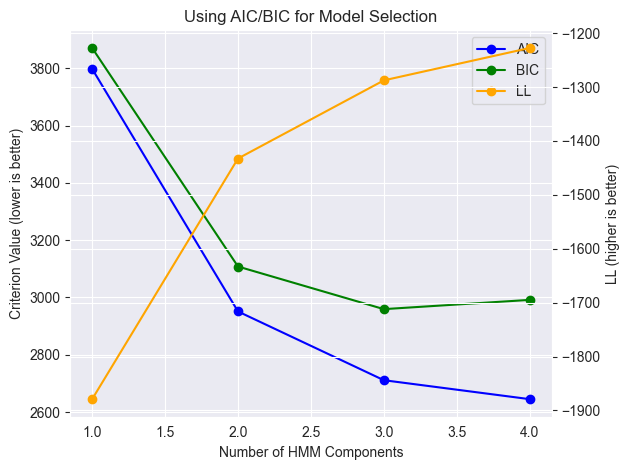

In [15]:
fig, ax = plt.subplots()
ln1 = ax.plot(ns, aics, label="AIC", color="blue", marker="o")
ln2 = ax.plot(ns, bics, label="BIC", color="green", marker="o")
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

In [16]:
chosen_model = GaussianHMM(
    n_components=3,
    covariance_type="full",
    n_iter=1000,
    random_state=42,
    verbose=False
)
chosen_model.fit(X)

GaussianHMM(covariance_type='full', n_components=3, n_iter=1000,
            random_state=42)

### 6. inspect estimated parameters and transition matrix

In [17]:
np.set_printoptions(precision=3, suppress=True)

print("Means for each regime (standardised units):")
display(pd.DataFrame(chosen_model.means_,
                     columns=Z.columns).style.format("{:+.2f}"))

print("\nCovariance matrices (first regime shown):")
print(pd.DataFrame(chosen_model.covars_[0],
                   index=Z.columns, columns=Z.columns))

print("\nTransition matrix:")
print(pd.DataFrame(chosen_model.transmat_).round(3))


Means for each regime (standardised units):


,gdp_yoy,inf_yoy,rate_3m_d1,rate_10y_d1,unemployment_d1
0,+0.01,-0.40,+0.09,-0.07,-0.14
1,+0.41,-0.04,-0.11,-0.03,-0.01
2,-0.98,+1.15,+0.02,+0.26,+0.39



Covariance matrices (first regime shown):
                  gdp_yoy   inf_yoy  rate_3m_d1  rate_10y_d1  unemployment_d1
gdp_yoy          0.169635  0.029260    0.029870     0.022023        -0.013644
inf_yoy          0.029260  0.121391    0.047127     0.024837         0.004612
rate_3m_d1       0.029870  0.047127    0.160507     0.149463        -0.018948
rate_10y_d1      0.022023  0.024837    0.149463     0.756411        -0.033614
unemployment_d1 -0.013644  0.004612   -0.018948    -0.033614         0.044489

Transition matrix:
       0      1      2
0  0.944  0.056  0.000
1  0.047  0.907  0.046
2  0.059  0.069  0.872


**interpretation:**
- checkout the sign of the means
    - seems like regime 3 (negative GDP growth and increasing unemployment) is representative or recession (bad regime)
    - the other two are harder to interpret into concrete "good" "neutral" buckets
- the diagonal of the transition matrix is close to one which shows regime persistence, would be interesting to see how this looks while using a MS-VAR model instead


### 7. smoothed state probabilities
   - `predict_proba` gives posteriors $\gamma_{t}(s) = P(S_t=s \mid X_{1:T})$

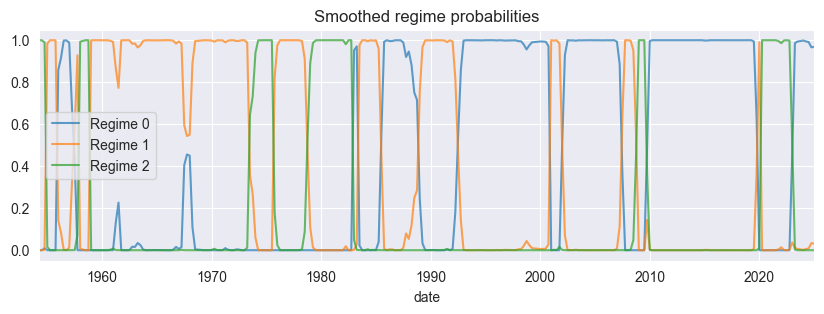

In [19]:
gamma = pd.DataFrame(chosen_model.predict_proba(X),
                     index=dates,
                     columns=[f"Regime {s}" for s in range(3)])

fig, ax = plt.subplots(figsize=(10, 3))
gamma.plot(ax=ax, alpha=0.7)
ax.set_title("Smoothed regime probabilities")
plt.show()


**do the same but with GDP overlayed**

In [20]:
gdp = pd.read_csv("data/macro_panel.csv", index_col=0, parse_dates=True)["gdp_yoy"]
gdp

date
1954-06-30    -9.835032
1954-09-30    -3.085192
1954-12-31    10.768225
1955-03-31    23.949307
1955-06-30    29.969666
                ...    
2024-03-31    11.442103
2024-06-30    11.966597
2024-09-30    10.729869
2024-12-31    10.008472
2025-03-31     8.116101
Name: gdp_yoy, Length: 284, dtype: float64

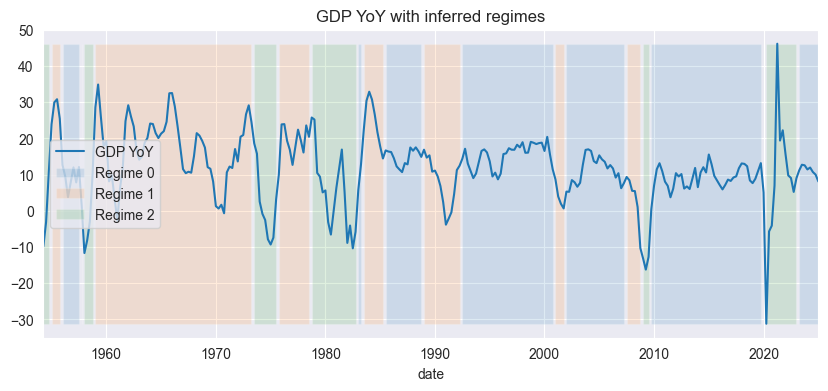

In [21]:
state_seq = chosen_model.predict(X)

fig, ax = plt.subplots(figsize=(10, 4))
gdp.plot(ax=ax, label="GDP YoY")
for s in range(3):
    mask = (state_seq == s)
    ax.fill_between(gdp.index, gdp.min(), gdp.max(),
                    where=mask, alpha=0.15,
                    label=f"Regime {s}")
ax.legend()
ax.set_title("GDP YoY with inferred regimes")
plt.show()

### 8. EM log-likelihood convergence plot and expected duration of regimes

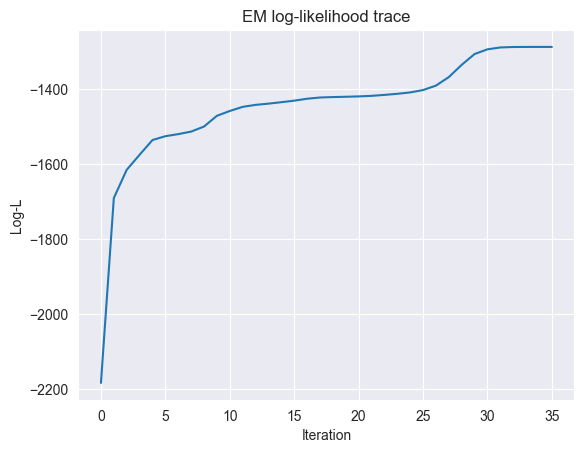

Regime 0    17.9
Regime 1    10.7
Regime 2     7.8
Name: Expected duration (quarters), dtype: float64


In [25]:
plt.plot(chosen_model.monitor_.history)
plt.title("EM log-likelihood trace")
plt.xlabel("Iteration"); plt.ylabel("Log-L")
plt.show()

dur = 1 / (1 - np.diag(chosen_model.transmat_))
print(pd.Series(dur, index=[f"Regime {i}" for i in range(3)]).round(1)
      .rename("Expected duration (quarters)"))


**^ shows regime 3 (the one we identified as recessionary) has the lowest expected duration, which makes sense economically**